In [15]:
import pandas as pd

# Load the raw file
df = pd.read_csv(r"C:\Users\LENOVO\cleaned_ckd_data.csv")

# Show the first few rows
print(df.head())
print(df.columns)
print(df.dtypes)


   id   age    bp     sg   al   su  rbc  pc  pcc  ba  ...  hemo      wc   rc  \
0   0  48.0  80.0  1.020  1.0  0.0    0   0    0   0  ...  15.4  7800.0  5.2   
1   1   7.0  50.0  1.020  4.0  0.0    0   0    0   0  ...  11.3  6000.0  5.2   
2   2  62.0  80.0  1.010  2.0  3.0    0   0    0   0  ...   9.6  7500.0  5.2   
3   3  48.0  70.0  1.005  4.0  0.0    0   1    1   0  ...  11.2  6700.0  3.9   
4   4  51.0  80.0  1.010  2.0  0.0    0   0    0   0  ...  11.6  7300.0  4.6   

   htn  dm  cad  appet  pe  ane  classification  
0    1   1    0      1   0    0               1  
1    0   0    0      1   0    0               1  
2    0   1    0      0   0    1               1  
3    1   0    0      0   1    1               1  
4    0   0    0      1   0    0               1  

[5 rows x 25 columns]
Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification']

In [19]:
import pandas as pd

# Load data
df = pd.read_csv(r"C:\Users\LENOVO\cleaned_ckd_data.csv")

# Drop the 'id' column
df.drop(columns=['id'], inplace=True)

# Separate features and target
X = df.drop(columns=['classification'])
y = df['classification']

# Check for missing values
print("Missing values per column:\n", X.isnull().sum())

# Optionally, fill missing values with median
X = X.fillna(X.median(numeric_only=True))

# Confirm no missing values remain
print("\n✅ Final check for missing:\n", X.isnull().sum().sum())

# Save cleaned version (optional)
df_cleaned = X.copy()
df_cleaned['classification'] = y
df_cleaned.to_csv("final_ckd_data.csv", index=False)
print("\n✅ Cleaned data saved as final_ckd_data.csv")


Missing values per column:
 age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
wc       0
rc       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64

✅ Final check for missing:
 0

✅ Cleaned data saved as final_ckd_data.csv


In [18]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,...,15.4,7800.0,5.2,1,1,0,1,0,0,1
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,121.0,...,11.3,6000.0,5.2,0,0,0,1,0,0,1
2,62.0,80.0,1.010,2.0,3.0,0,0,0,0,423.0,...,9.6,7500.0,5.2,0,1,0,0,0,1,1
3,48.0,70.0,1.005,4.0,0.0,0,1,1,0,117.0,...,11.2,6700.0,3.9,1,0,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,0,0,0,0,106.0,...,11.6,7300.0,4.6,0,0,0,1,0,0,1


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import optuna
import pickle

# Load cleaned dataset
df = pd.read_csv("final_ckd_data.csv")
X = df.drop(columns=["classification"])
y = df["classification"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective for Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Train final model with best params
best_model = xgb.XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric="logloss")
best_model.fit(X_train, y_train)

# Save model
pickle.dump(best_model, open("xgb_ckd_model", "wb"))
print("\n✅ Model trained and saved as xgb_ckd_model")

# Evaluate
preds = best_model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"📈 Final Accuracy: {acc:.4f}")


[I 2025-05-11 16:37:33,445] A new study created in memory with name: no-name-813deeff-022b-4320-9d97-7cf9a8654827
C:\Notes\Ana\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:37:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-05-11 16:37:33,726] Trial 0 finished with value: 0.975 and parameters: {'max_depth': 2, 'learning_rate': 0.09115731333616296, 'n_estimators': 132, 'gamma': 4.5703051486379405, 'min_child_weight': 8, 'subsample': 0.7728707221570852, 'colsample_bytree': 0.5645885485018302}. Best is trial 0 with value: 0.975.
C:\Notes\Ana\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:37:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-05-11 16:37:33,951] Trial 1 finished with value: 0.975 and parameters: {


✅ Model trained and saved as xgb_ckd_model
📈 Final Accuracy: 0.9875


🔍 Top 10 Features by Importance:

   feature  importance
14    hemo    0.253143
18      dm    0.155315
2       sg    0.126052
11      sc    0.102166
17     htn    0.098937
3       al    0.081664
16      rc    0.053803
9      bgr    0.025686
12     sod    0.024718
0      age    0.020820


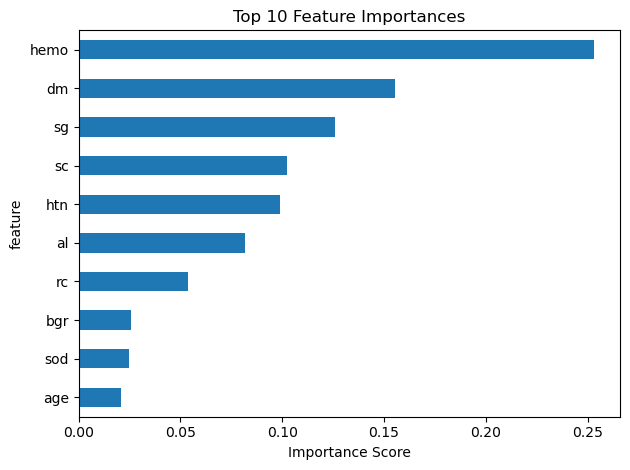

In [21]:
import pandas as pd
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt

# Load trained model
model = pickle.load(open("xgb_ckd_model", "rb"))

# Get feature names from the training data
df = pd.read_csv("final_ckd_data.csv")
X = df.drop(columns=["classification"])

# Ensure model uses the correct feature names
model.get_booster().feature_names = list(X.columns)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': model.get_booster().feature_names,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Display top 10 features
print("🔍 Top 10 Features by Importance:\n")
print(importance_df.head(10))

# Optional: Plot feature importance
importance_df.head(10).plot(kind='barh', x='feature', y='importance', legend=False)
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()
